## Summary
- Manage the data
- Features engineering
- Split the data
- Standardization
- Principal component analysis
- Machine Learning modelling
- Compute the profit
- Automatization

In [19]:
# Import libraries 
from matplotlib import cycler
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import ta 

import yfinance as yf
import plotly.graph_objs as go
from plotly.subplots import make_subplots

In [20]:
facecolor_theme = '#1f1f1f'

colors = cycler('color', 
                ['#669FEE', '#66EE91', '#9988DD', '#EECC55', '#88BB44', '#FFBBBB'])
plt.rc('figure', facecolor = facecolor_theme)
plt.rc('axes', facecolor = facecolor_theme, edgecolor = 'white',
       axisbelow = True, grid = True, prop_cycle = colors,
       labelcolor = 'white')
plt.rc('xtick', color = 'white')
plt.rc('ytick', direction = 'out', color = 'white')
plt.rc('legend', facecolor = facecolor_theme, edgecolor = facecolor_theme)
plt.rc('text', color = 'white')
plt.rc('figure', facecolor = facecolor_theme)

# Set grid lines to be thin
plt.rc('grid', linewidth=0.1, color='white')

import warnings
warnings.filterwarnings('ignore')

In [21]:
from binance import Client
from dotenv import load_dotenv
import os 

# Chargez les variables d'environnement à partir du fichier .env
load_dotenv()

# Accédez à vos clés d'API à l'aide de variables d'environnement
API_KEY = os.getenv("BINANCE_API_KEY")
SECRET_KEY = os.getenv("BINANCE_API_SECRET")

client = Client(API_KEY, SECRET_KEY) 

In [22]:
def BackTest(asset, serie, annualiazed_scalar=252):
  global serie_print

  # FUNCTION TO BUT THE RIGHT DATE FORMAT
  def date_format(df):
    df.index.name = "date_time"
    df = df.reset_index(drop=False)
    df['date_time'] = pd.to_datetime(df['date_time'])
    df['date_time'] = df['date_time'].dt.date
    df = df.set_index('date_time')

    return df
  
  def drawdown_function(serie):
    # We compute Cumsum of the returns
    cum = serie.dropna().cumsum() + 1

    # We compute max of the cumsum on the period (accumulate max)
    running_max = np.maximum.accumulate(cum)

    # We compute drawdown
    drawdown = cum / running_max - 1
    
    return drawdown

  # Import the benchmark
  sp500 = yf.download("^GSPC")["Adj Close"].pct_change(1)
  
  # Change the name
  sp500.name = "SP500"

  try:
    # Concat the returns and the sp500
    val = pd.concat((serie,sp500), axis=1).dropna()

  except:
    # Put the right date format
    sp500 = date_format(sp500)
    serie = date_format(serie)

    # Concat the returns and the sp500
    val = pd.concat((serie, sp500), axis=1).dropna()

  # Compute the drawdown
  drawdown = drawdown_function(serie) * 100
  
  # Compute max drawdown
  max_drawdown = -np.min(drawdown)

  # Put a subplots
  fig, (cum, dra) = plt.subplots(1, 2, figsize=(20, 6))
  
  # Put a Suptitle
  fig.suptitle("Backtesting", size=20)

  # Returns cumsum chart
  cum.plot(serie.cumsum()*100, color="#39B3C7")

  # SP500 cumsum chart
  cum.plot(val["SP500"].cumsum()*100, color="#B85A0F")

  # Put a legend
  cum.legend([f"Portfolio {asset}", "SP500"])
  
  # Set individual title
  cum.set_title("Cumulative Return", size=13)

  cum.set_ylabel("Cumulative Return %", size=11)

  # Put the drawdown
  dra.fill_between(drawdown.index, 0, drawdown.values.flatten(), color="#C73954", alpha=0.65)

  # Set individual title
  dra.set_title("Drawdown", size=13)

  dra.set_ylabel("drawdown in %", size=11)

  # Plot the graph
  plt.show()

  try:
    serie = serie["return"]
  except:
    pass
  
  serie_print = serie
  # Compute the sortino
  sortino = np.sqrt(annualiazed_scalar) * serie.mean()/serie.loc[serie<0].std()

  # Compute the beta
  beta = np.cov(val[["return", "SP500"]].values,rowvar=False)[0][1] / np.var(val["SP500"].values)

  # Compute the alpha
  alpha = annualiazed_scalar * (serie.mean() - beta*serie.mean())

  # Print the statistics
  print(f"Sortino: {np.round(sortino,3)}")
  print(f"Beta: {np.round(beta,3)}")
  print(f"Alpha: {np.round(alpha*100,3)} %")
  try:
    print(f"MaxDrawdown: {np.round(max_drawdown[0],3)} %")
  except:
    print(f"MaxDrawdown: {np.round(max_drawdown,3)} %")

In [23]:
# Preprocessing function
def preprocessing(asset, interval):
    
    klines  = client.get_historical_klines(asset, interval)
    klines = [[x[0], float(x[1]), float(x[2]), float(x[3]),
              float(x[4]), float(x[5])] for x in klines]
    klines = pd.DataFrame(klines, columns =['date', 'open',
                                           'high', 'low', 
                                            'close', 'volume'])
    klines['date'] = pd.to_datetime(klines['date'], unit = 'ms')
    klines = klines.set_index('date')
    
    return klines

In [24]:
asset = "ETH"
interval = Client.KLINE_INTERVAL_1DAY   

# Manage the data
df = preprocessing(f"{asset}USDT", interval)

In [25]:
df.head()

,open,high,low,close,volume
date,,,,,
2021-02-10,1769.14,1837.86,1680.00,1740.78,1.219932e+06
2021-02-11,1740.76,1819.00,1703.44,1785.62,7.350798e+05
2021-02-12,1785.83,1864.88,1739.88,1840.26,9.096002e+05
2021-02-13,1840.24,1871.72,1765.00,1814.96,7.675891e+05
2021-02-14,1815.25,1850.00,1784.11,1800.42,6.752618e+05


In [26]:
def feature_engineering(df, lag=10):
    """ Create new variables"""
    
    # We copy the dataframe to avoid interferences in the data
    df_copy = df.dropna().copy()
    
    # Create the returns
    df_copy["return"] = df_copy["close"].pct_change(1)
    df_copy['return_lag'] = df_copy['close'].pct_change(1)

    # Create the SMAs
    df_copy["sma 15"] = df_copy[["close"]].rolling(15).mean().shift(1)
    df_copy["sma 60"] = df_copy[["close"]].rolling(60).mean().shift(1)
    
    # Create the volatilities
    df_copy["msd 10"] = df_copy[["return"]].rolling(10).std().shift(1)
    df_copy["msd 30"] = df_copy[["return"]].rolling(30).std().shift(1)
    
    # Create the Ichimoku
    IC = ta.trend.IchimokuIndicator(df_copy['high'], df_copy['low'])
    df_copy['ichimoku_a'] = IC.ichimoku_a().shift(lag)
    df_copy['ichimoku_b'] = IC.ichimoku_b().shift(lag)
    df_copy['ichimoku_base'] = IC.ichimoku_base_line().shift(lag)
    df_copy['ichimoku_conversion'] = IC.ichimoku_conversion_line().shift(lag)
    
    # Create the RSI
    RSI = ta.momentum.RSIIndicator(df_copy["close"], window= 14, fillna = False)
    df_copy["rsi"] = RSI.rsi().shift(1)
    
    return df_copy.dropna()

In [27]:
asset = 'ETH' 

# Use defined functions 
df = preprocessing(f"{asset}USDT", interval)
dfc = feature_engineering(df, lag=1)

# First lines 
dfc.head()

,open,high,low,close,volume,return,return_lag,sma 15,sma 60,msd 10,msd 30,ichimoku_a,ichimoku_b,ichimoku_base,ichimoku_conversion,rsi
date,,,,,,,,,,,,,,,,
2021-04-11,2133.49,2165.02,2113.40,2151.36,392265.50773,0.008376,0.008376,1975.069333,1788.071333,0.048020,0.042716,1966.7325,1746.590,1868.460,2065.005,62.687005
2021-04-12,2151.42,2203.46,2102.00,2137.69,579093.35694,-0.006354,-0.006354,2004.318000,1794.914333,0.047782,0.042085,1966.7325,1746.590,1868.460,2065.005,63.446836
2021-04-13,2137.86,2318.00,2135.53,2299.19,782608.62090,0.075549,0.075549,2034.363333,1800.782167,0.040126,0.039255,1968.4625,1748.320,1870.190,2066.735,62.400020
2021-04-14,2299.19,2447.29,2281.33,2432.60,972931.60866,0.058025,0.058025,2066.526667,1808.431000,0.040426,0.040467,2025.7325,1805.590,1927.460,2124.005,68.923519
2021-04-15,2432.59,2543.47,2400.00,2514.04,681950.96645,0.033479,0.033479,2106.002667,1818.725000,0.042415,0.040815,2090.3775,1870.235,1992.105,2188.650,73.078696


Text(0.5, 0, 'Time')

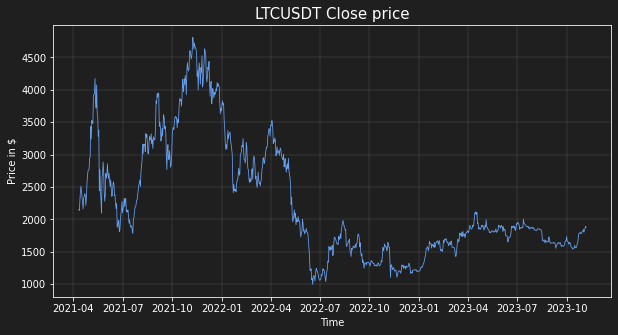

In [28]:
plt.figure(figsize=(10, 5))
plt.plot(dfc['close'], linewidth=0.8)
plt.title('LTCUSDT Close price', fontsize=15)
plt.ylabel('Price in $')
plt.xlabel('Time')

Text(0.5, 1.0, 'SMA 15&60 and close')

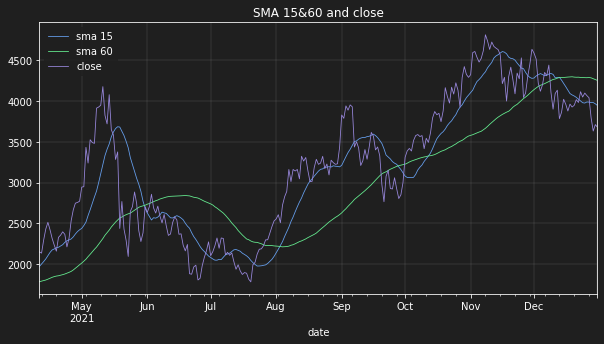

In [29]:
dfc[["sma 15", "sma 60", "close"]].loc['2021'].plot(figsize=(10,5), linewidth=0.8)
plt.title("SMA 15&60 and close")

Text(0.5, 1.0, 'Relative Strengh Index (RSI)')

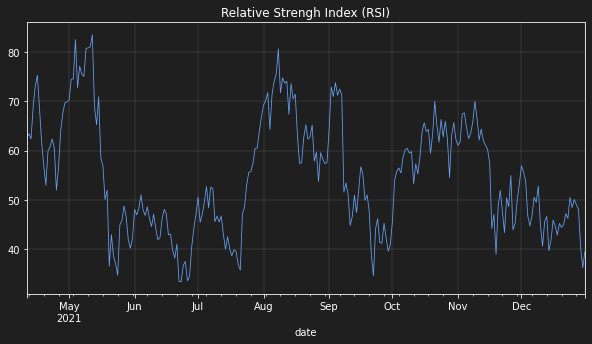

In [30]:
dfc["rsi"].loc['2021'].plot(figsize=(10,5), linewidth=0.8)
plt.title("Relative Strengh Index (RSI)")

Text(0.5, 1.0, 'MSD 10&30 and return')

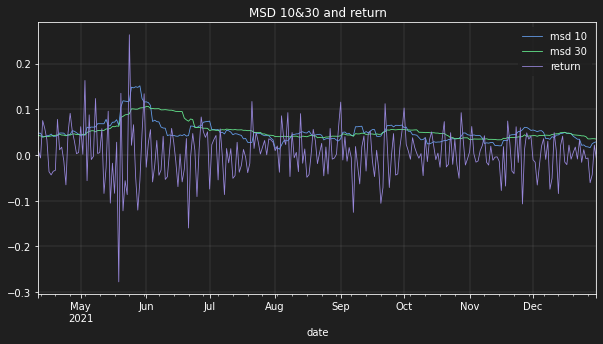

In [31]:
# Plotting MSD
dfc[["msd 10", "msd 30", "return"]].loc["2021"].plot(figsize=(10,5), linewidth=0.8)
plt.title("MSD 10&30 and return")

In [32]:
dfc.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 940 entries, 2021-04-11 to 2023-11-06
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   open                 940 non-null    float64
 1   high                 940 non-null    float64
 2   low                  940 non-null    float64
 3   close                940 non-null    float64
 4   volume               940 non-null    float64
 5   return               940 non-null    float64
 6   return_lag           940 non-null    float64
 7   sma 15               940 non-null    float64
 8   sma 60               940 non-null    float64
 9   msd 10               940 non-null    float64
 10  msd 30               940 non-null    float64
 11  ichimoku_a           940 non-null    float64
 12  ichimoku_b           940 non-null    float64
 13  ichimoku_base        940 non-null    float64
 14  ichimoku_conversion  940 non-null    float64
 15  rsi                  

In [33]:
### Create dummy variable 

# 0 : the variation is lower than percentile 67
# 1 : the variation is higher than percentile 67

percentile = np.quantile(dfc['return_lag'].dropna(), 0.67)

dfc['dummy'] = 0
dfc.loc[dfc['return_lag'] > percentile, 'dummy'] = 1 

In [34]:
### Split the Data 

# Percentage train set 
split = int(0.90 * len(dfc))

# Train set creation 
X_train = dfc.iloc[:split, 7:-1]
y_train = dfc['dummy'].iloc[:split]

# Test set creation
X_test = dfc.iloc[split:, 7:-1]
y_test = dfc['dummy'].iloc[split:]

In [35]:
### Standardisation 
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.fit_transform(X_test)

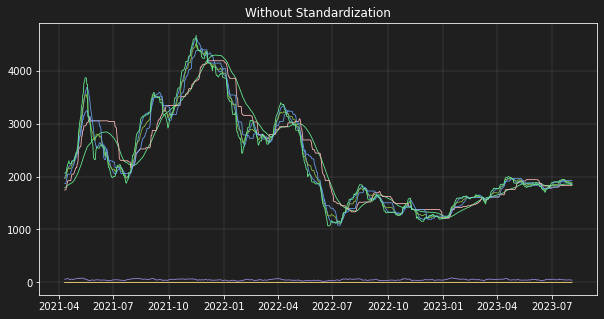

In [36]:
plt.figure(figsize=(10, 5))
plt.plot(X_train, linewidth=0.8)
plt.title("Without Standardization")
plt.show()

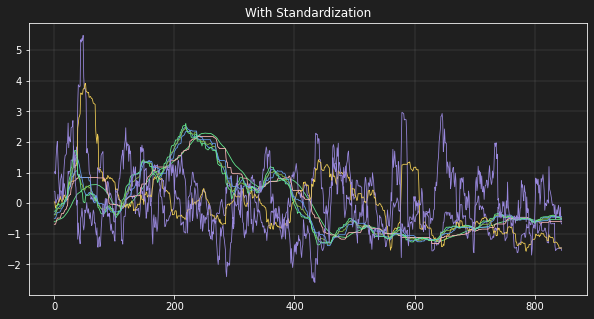

In [37]:
plt.figure(figsize=(10, 5))
plt.plot(X_train_sc, linewidth=0.8)
plt.title("With Standardization")
plt.show()

In [38]:
### Dimension Reduction
from sklearn.decomposition import PCA

pca = PCA(n_components=5)

X_train_pca = pca.fit_transform(X_train_sc)
X_test_pca = pca.fit_transform(X_test_sc)

In [39]:
### Machine Learning Modelling 

# Import the class
from sklearn.ensemble import RandomForestClassifier 

# Initialize the class 
cla = RandomForestClassifier(max_depth=3, n_estimators=100)

# Fit the model 
cla.fit(X_train_pca, y_train)

RandomForestClassifier(max_depth=3)

<AxesSubplot:xlabel='date'>

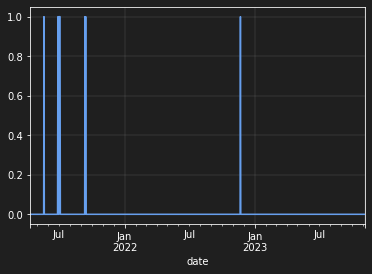

In [40]:
### Prediction 

# Create predictions for the whole dataset 
X = np.concatenate((X_train_pca, X_test_pca), axis=0)

dfc['prediction'] = cla.predict(X)

# We verify that the algorithm doesn't predict only way (positive or negative)
dfc['prediction'].plot()

[*********************100%***********************]  1 of 1 completed


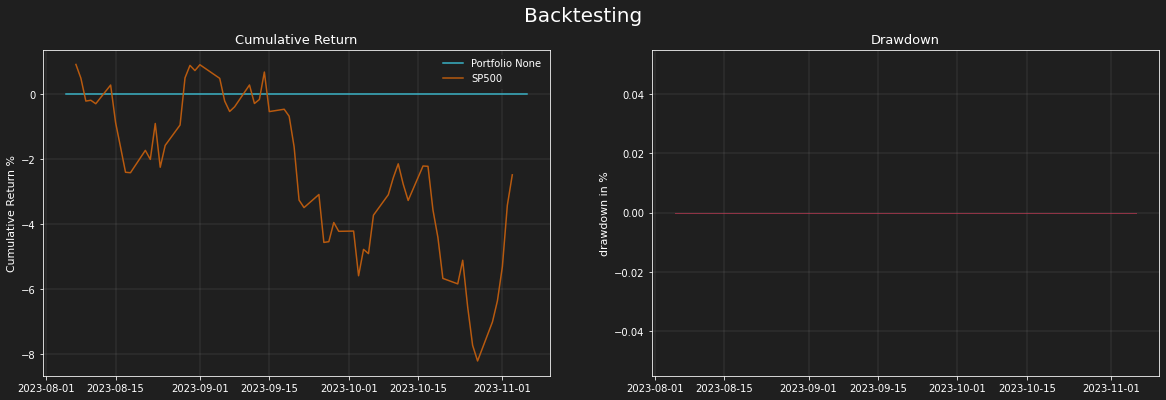

Sortino: nan
Beta: 0.0
Alpha: 0.0 %
MaxDrawdown: -0.0 %


In [43]:
### Compute the profit 

# Compute the position
dfc["position"] = dfc["prediction"]

# Compute the returns
#dfc["strategy"] = np.array([dfc["return"].shift(i) for i in range(1)]).sum(axis=0) * (dfc["position"].shift(1))
dfc["strategy"] = dfc["return"] * dfc["position"].shift(1)

dfc["return"] = dfc["strategy"]

BackTest(asset=None, serie = dfc["return"].iloc[split:])

In [ ]:
def RandomForest(asset,lag=10):

  def feature_engineering(df, lag=10):
    """ Create new variables"""
    lag = 10
    
    # We copy the dataframe to avoid interferences in the data
    df_copy = df.dropna().copy()
    
    # Create the returns
    df_copy["returns"] = df_copy["close"].pct_change(1)
    df_copy["returns_lag"] = df_copy["close"].pct_change(lag)
    # Create the volatilities
    df_copy["MSD 10"] = df_copy[["returns"]].rolling(10).std().shift(lag)
    df_copy["MSD 30"] = df_copy[["returns"]].rolling(30).std().shift(lag)
    
    # Create the Ichimoku
    IC = ta.trend.IchimokuIndicator(df_copy["high"], df_copy["low"])
    df_copy["ichimoku_a"] = IC.ichimoku_a().shift(lag)
    df_copy["ichimoku_b"] = IC.ichimoku_b().shift(lag)
    df_copy["ichimoku_base"] = IC.ichimoku_base_line().shift(lag)
    df_copy["ichimoku_conversion"] = IC.ichimoku_conversion_line().shift(lag)
    
    return df_copy.dropna()

  def preprocessing(asset, interval):
    
    klines  = client.get_historical_klines(asset, interval)
    klines = [[x[0], float(x[1]), float(x[2]), float(x[3]),
              float(x[4]), float(x[5])] for x in klines]
    klines = pd.DataFrame(klines, columns =['date', 'open',
                                           'high', 'low', 
                                            'close', 'volume'])
    klines['date'] = pd.to_datetime(klines['date'], unit = 'ms')
    klines = klines.set_index('date')
    
    return klines

  df = preprocessing(asset, interval)
  
  import ta
  
  dfc = feature_engineering(df, lag)
  
  dfc["dummy"] = 0
  dfc.loc[dfc["returns_lag"] > np.quantile(dfc["returns_lag"], 0.67), "dummy"] = 1

  # Percentage train set
  split = int(0.90*len(dfc))

  # Train set creation
  X_train = dfc.iloc[:split,7:-1]
  y_train = dfc[["dummy"]].iloc[:split]


  # Test set creation
  X_test = dfc.iloc[split:,7:-1]
  y_test = dfc[["dummy"]].iloc[split:]

  # STANDARDISATION
  from sklearn.preprocessing import StandardScaler

  sc = StandardScaler()

  X_train_sc = sc.fit_transform(X_train)
  X_test_sc = sc.transform(X_test)

  # DIMENSION REDUCTION
  from sklearn.decomposition import PCA
  pca = PCA(n_components=5)

  X_train_pca = pca.fit_transform(X_train_sc)
  X_test_pca = pca.transform(X_test_sc)

  # Import the class
  from sklearn.ensemble import RandomForestClassifier

  # Initialize the class
  reg = RandomForestClassifier(max_depth=10, n_estimators=100)

  # Fit the model
  np.random.seed(56)
  reg.fit(X_train_pca, y_train)

  # Create predictions for the whole dataset
  X = np.concatenate((X_train_pca, X_test_pca), axis=0)

  #dfc["proba"] = reg.predict_proba(X)[:,0:1].reshape(-1,1)
  dfc["prediction"] = reg.predict(X)

  import yfinance as yf
  # Compute the position
  dfc["position"] = dfc["prediction"]

  # Compute the returns
  dfc["strategy"] = np.array([dfc["returns"].shift(i) for i in range(lag)]).sum(axis=0) * (dfc["position"].shift(lag))
  #dfc["strategy"] = dfc["returns"] * dfc["position"].shift(lag)

  dfc["return"] = dfc["strategy"].dropna()
  
  return dfc["return"].iloc[split:]/lag

[*********************100%***********************]  1 of 1 completed


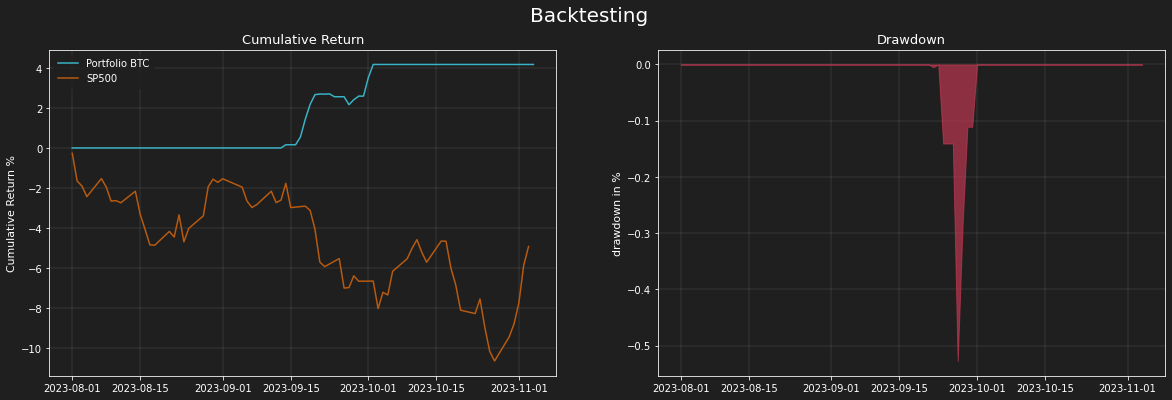

Sortino: 1.577
Beta: -0.004
Alpha: 2.269 %
MaxDrawdown: 0.527 %
[*********************100%***********************]  1 of 1 completed


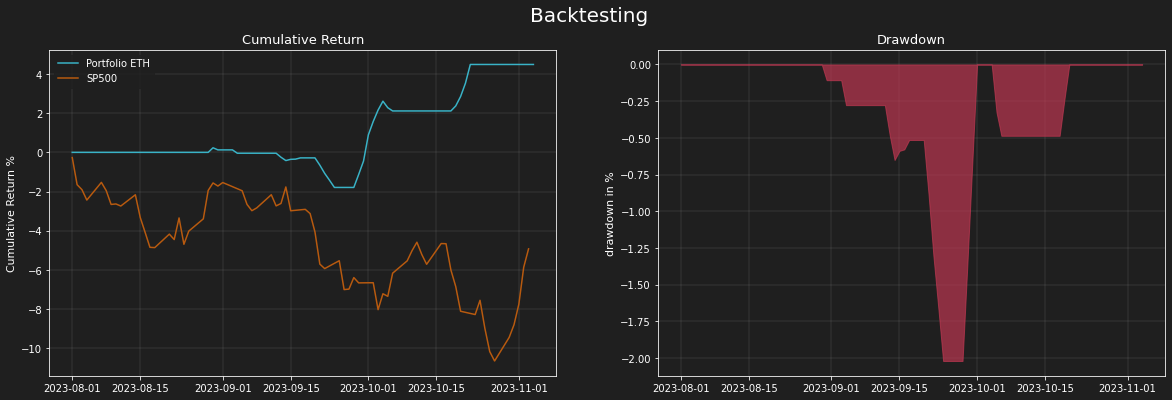

Sortino: 2.989
Beta: -0.02
Alpha: 2.479 %
MaxDrawdown: 2.02 %
[*********************100%***********************]  1 of 1 completed


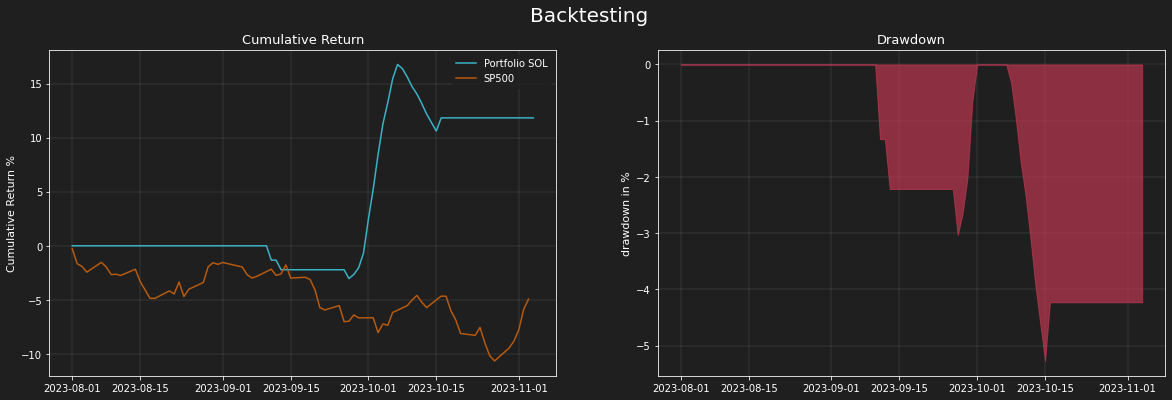

Sortino: 3.934
Beta: 0.021
Alpha: 6.274 %
MaxDrawdown: 5.273 %
[*********************100%***********************]  1 of 1 completed


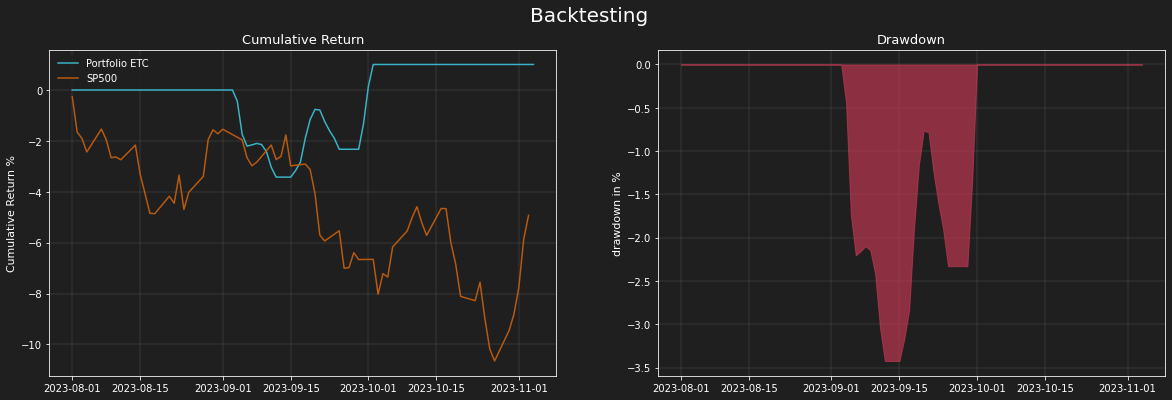

Sortino: 0.233
Beta: 0.003
Alpha: 0.542 %
MaxDrawdown: 3.424 %
[*********************100%***********************]  1 of 1 completed


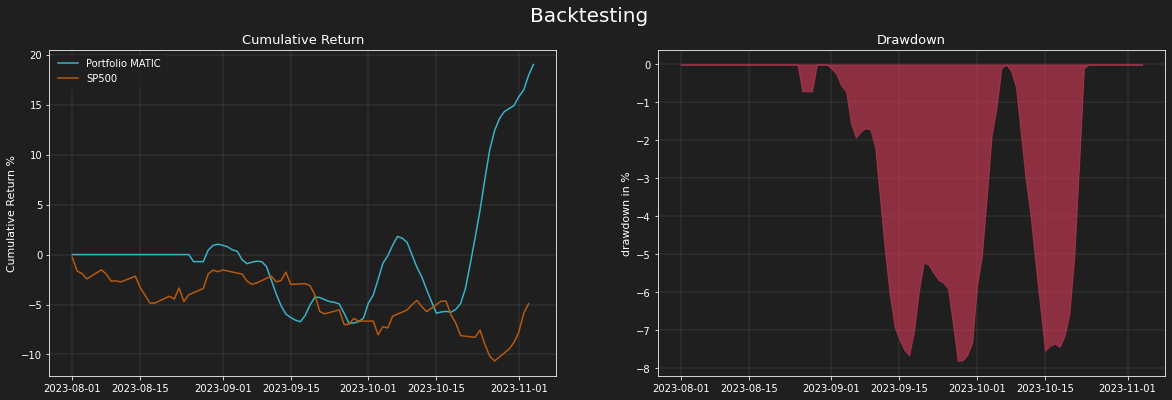

Sortino: 2.997
Beta: -0.01
Alpha: 10.409 %
MaxDrawdown: 7.821 %


In [ ]:
assets_list = ["BTC", "ETH", "SOL", "ETC", 'MATIC']
interval = Client.KLINE_INTERVAL_1DAY   
returns = pd.DataFrame()
for asset in assets_list:
  ret = RandomForest(f"{asset}USDT", lag=7)
  returns = pd.concat((returns, ret), axis=1)
  BackTest(asset, ret, 52)